# Feature Selection

In [17]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('error')

train = pd.read_csv(
    '../../data/data_after_Feature_Generation/train_encoded.csv')
test = pd.read_csv('../../data/data_after_Feature_Generation/test_encoded.csv')

X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']

feature_names = X_train.columns.tolist()
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_test, y_test, feature_names=feature_names)

model = CatBoostClassifier(
    iterations=1000,
    random_seed=42,
    silent=True
)

summary = model.select_features(
    X=train_pool,
    eval_set=test_pool,
    features_for_select=feature_names,
    num_features_to_select=50,
    steps=5,
    algorithm='RecursiveByLossFunctionChange',
    shap_calc_type='Regular',
    train_final_model=True,
    logging_level='Silent',
)

selected_features = summary['selected_features_names']
print(f"Selected features ({len(selected_features)}): {selected_features}")

Selected features (50): ['Yr_production_div_price_gr', 'married_encoded_div_Yr_production', 'product_encoded_div_Yr_production', 'Yr_production_div_channel_map_encoded', 'Yr_production_addition_category_encoded', 'KBM_multiplication_Bank_encoded', 'Bank_encoded_div_KBM', 'KBM_prol_est_multiplication_price_prc', 'Model_encoded_div_Age', 'passport_region_encoded_subtraction_discount', 'category_encoded_div_price_gr', 'kvs_type_encoded_div_price_gr', 'price_prc_multiplication_Brand_encoded', 'Filial_encoded_addition_product_encoded', 'Filial_encoded_subtraction_product_encoded', 'channel_map_encoded_subtraction_Filial_encoded', 'Filial_encoded_subtraction_sex_encoded', 'passport_region_encoded_multiplication_price_prc', 'passport_region_encoded_subtraction_Brand_encoded', 'passport_region_encoded_addition_GAP_encoded', 'Brand_encoded_addition_discount', 'product_encoded_subtraction_Model_encoded', 'GAP_encoded_multiplication_deduct_encoded', 'married_encoded_addition_Filial_encoded', 'ded

In [18]:
train_selected = train[['target'] + selected_features]
test_selected = test[['target'] + selected_features]

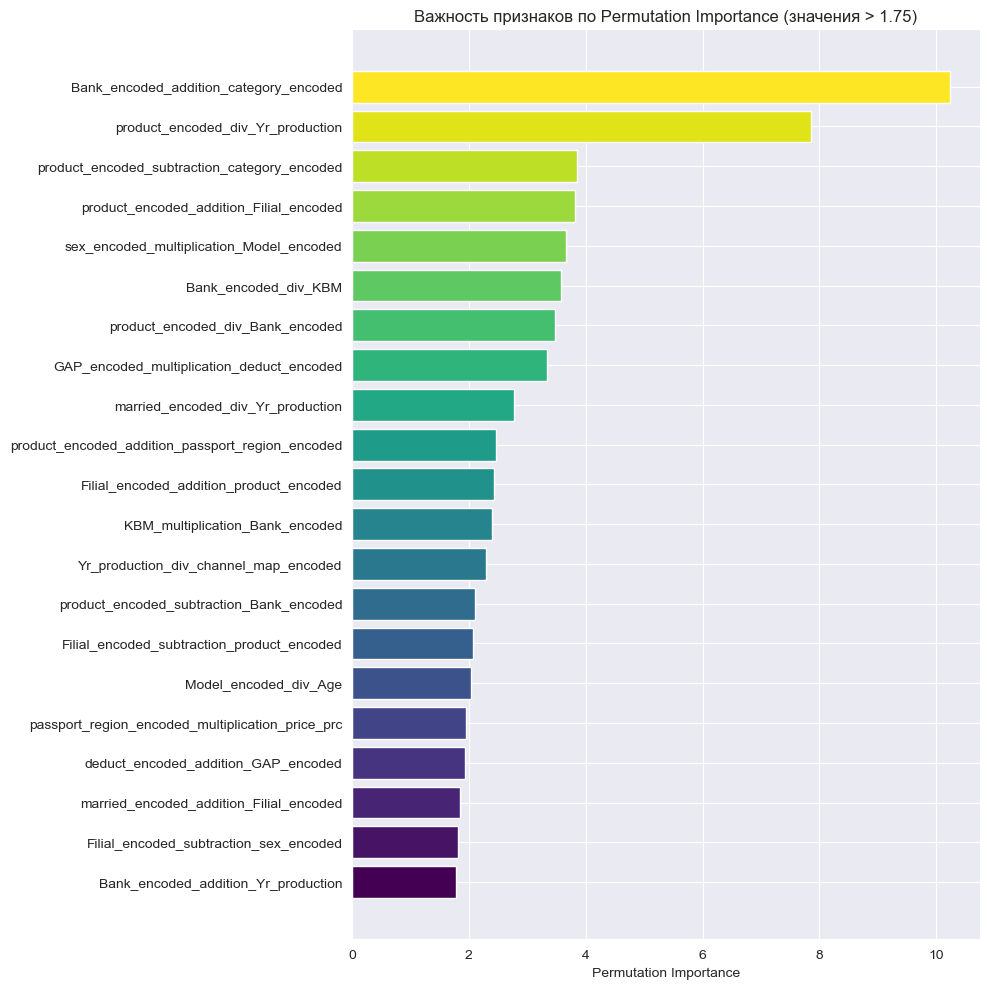

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool
from sklearn.model_selection import train_test_split

X = train_selected.drop('target', axis=1)
y = train_selected['target']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_test = test_selected.drop('target', axis=1)
y_test = test_selected['target']

feature_names = X_train.columns.tolist()
train_pool = Pool(X_train, y_train, feature_names=feature_names)
val_pool = Pool(X_val, y_val, feature_names=feature_names)
test_pool = Pool(X_test, y_test, feature_names=feature_names)

model.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=50
)

feature_importance_test = model.get_feature_importance(
    data=test_pool,
    type='FeatureImportance',
    prettified=True
)

features_df = feature_importance_test.sort_values('Importances',
                                                  ascending=True)
features_df_filtered = features_df[features_df['Importances'] > 1.75]

plt.figure(figsize=(10, 10))
plt.barh(features_df_filtered['Feature Id'],
         features_df_filtered['Importances'],
         color=plt.cm.viridis(np.linspace(0, 1, len(features_df_filtered))))
plt.xlabel('Permutation Importance')
plt.title('Важность признаков по Permutation Importance (значения > 1.75)')
plt.tight_layout()
plt.show()

Сохраним отфильтрованные признаки

In [23]:
selected_features = features_df_filtered['Feature Id'].tolist()

selected_features_with_target = selected_features + ['target']

train_selected = train_selected[selected_features_with_target]
test_selected = test_selected[selected_features_with_target]

Посмотрим на корреляцию между признаками

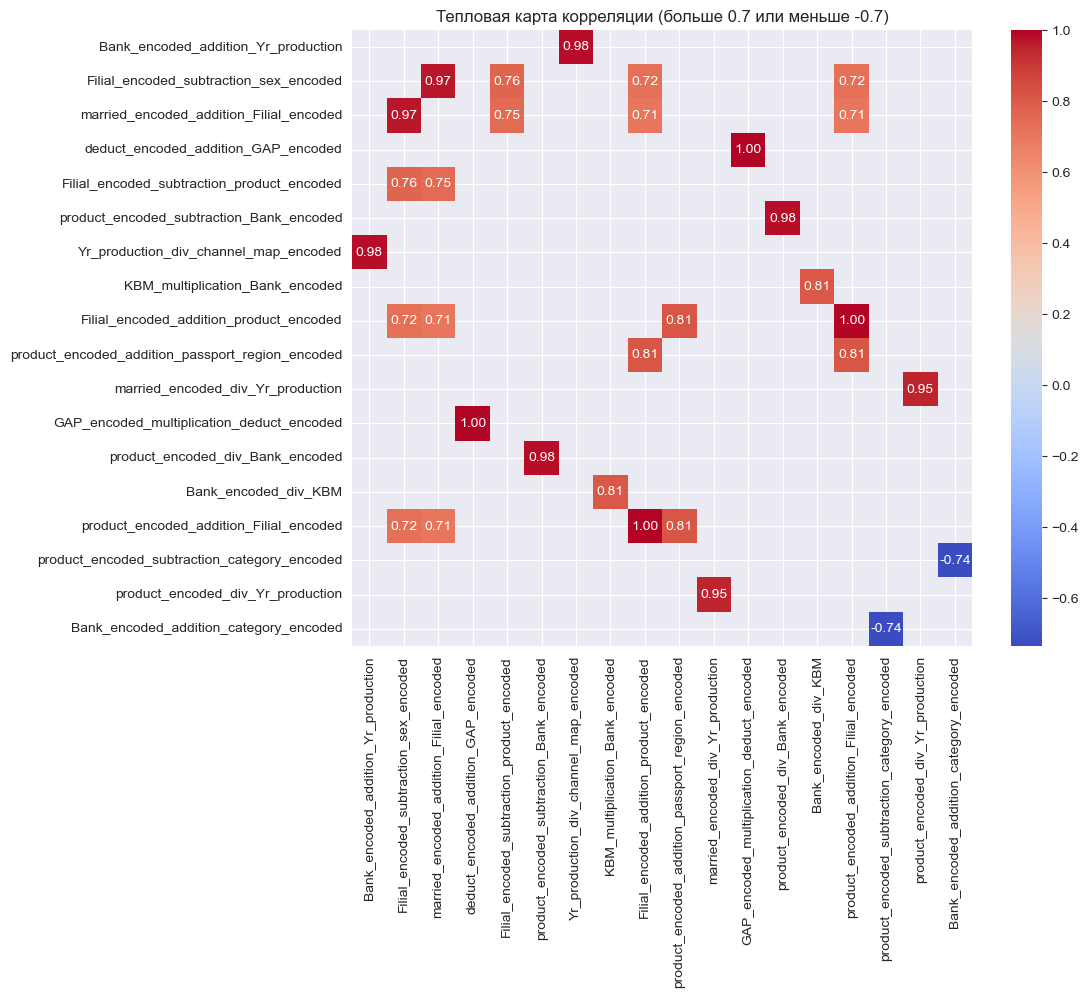

In [24]:
corr_matrix = train_selected.corr()

mask_high = corr_matrix > 0.7
mask_low = corr_matrix < -0.7
mask_combined = mask_high | mask_low

# Исключаем диагональ (корреляцию признака с самим собой)
np.fill_diagonal(mask_combined.values, False)

filtered_corr_matrix = corr_matrix.where(mask_combined)

filtered_corr_matrix = filtered_corr_matrix.dropna(axis=1, how='all').dropna(
    axis=0, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True
)
plt.title('Тепловая карта корреляции (больше 0.7 или меньше -0.7)')
plt.show()

Создадим датафрейм с сильно коррелирующими признаками и посмотрим на точность при их удалении

In [25]:
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape, dtype=bool)))

strong_pairs = []
for col in upper_triangle.columns:
    for idx in upper_triangle.index:
        if idx < col:
            corr_value = upper_triangle.loc[idx, col]
            if abs(corr_value) > 0.7:
                strong_pairs.append({
                    'Признак 1': idx,
                    'Признак 2': col,
                    'Корреляция': corr_value
                })

strong_corr_df = pd.DataFrame(strong_pairs)

strong_corr_df = strong_corr_df.iloc[
    np.argsort(np.abs(strong_corr_df['Корреляция']))[::-1]
].reset_index(drop=True)

strong_corr_df

,Признак 1,Признак 2,Корреляция
0,Filial_encoded_addition_product_encoded,product_encoded_addition_Filial_encoded,1.000000
1,Bank_encoded_addition_Yr_production,Yr_production_div_channel_map_encoded,0.981573
2,Filial_encoded_subtraction_sex_encoded,married_encoded_addition_Filial_encoded,0.966359
3,married_encoded_div_Yr_production,product_encoded_div_Yr_production,0.952211
4,Filial_encoded_addition_product_encoded,product_encoded_addition_passport_region_encoded,0.813474
5,Filial_encoded_subtraction_sex_encoded,product_encoded_addition_Filial_encoded,0.724471
6,married_encoded_addition_Filial_encoded,product_encoded_addition_Filial_encoded,0.707234


Далее начнем проходить по строкам датафрейма и удалять один из двух сильно коррелирующих признаков, пока не останется только один признак из каждой пары

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np


def evaluate_features(features, X, y):
    '''Функция для оценки точности модели CatBoostClassifier'''
    model = CatBoostClassifier(verbose=0, random_seed=42)
    scores = cross_val_score(model, X[features], y, cv=3, scoring='accuracy')
    return np.mean(scores)


X_train = train_selected.drop(columns=['target'])
y_train = train_selected['target']
features = X_train.columns.tolist()

# Базовый уровень точности
base_accuracy = evaluate_features(features, X_train, y_train)
print(f'Базовая точность: {base_accuracy:.4f}')

remaining_features = features.copy()

# Проход по всем парам коррелирующих признаков
for _, row in strong_corr_df.iterrows():
    feature1 = row['Признак 1']
    feature2 = row['Признак 2']

    if feature1 not in remaining_features or feature2 not in remaining_features:
        continue

    accuracy_without1 = evaluate_features(
        [f for f in remaining_features if f != feature1],
        X_train,
        y_train
    )
    accuracy_without2 = evaluate_features(
        [f for f in remaining_features if f != feature2],
        X_train,
        y_train
    )

    # Выбираем признак для удаления
    if accuracy_without1 >= accuracy_without2:
        removed_feature = feature2
        remaining_features.remove(feature2)
    else:
        removed_feature = feature1
        remaining_features.remove(feature1)

    print(
        f'Удален {removed_feature} | Точность без {feature1}: {accuracy_without1:.4f} | без {feature2}: {accuracy_without2:.4f}')

final_accuracy = evaluate_features(remaining_features, X_train, y_train)
print(f'\nФинальная точность: {final_accuracy:.4f}')
print(f'Удалено признаков: {len(features) - len(remaining_features)}')
print(f'Оставшиеся признаки: {remaining_features}')

Базовая точность: 0.7253
Удален product_encoded_addition_Filial_encoded | Точность без Filial_encoded_addition_product_encoded: 0.7267 | без product_encoded_addition_Filial_encoded: 0.7229
Удален Bank_encoded_addition_Yr_production | Точность без Bank_encoded_addition_Yr_production: 0.7240 | без Yr_production_div_channel_map_encoded: 0.7249
Удален Filial_encoded_subtraction_sex_encoded | Точность без Filial_encoded_subtraction_sex_encoded: 0.7250 | без married_encoded_addition_Filial_encoded: 0.7265
Удален product_encoded_div_Yr_production | Точность без married_encoded_div_Yr_production: 0.7252 | без product_encoded_div_Yr_production: 0.7246
Удален Filial_encoded_addition_product_encoded | Точность без Filial_encoded_addition_product_encoded: 0.7294 | без product_encoded_addition_passport_region_encoded: 0.7297

Финальная точность: 0.7294
Удалено признаков: 5
Оставшиеся признаки: ['married_encoded_addition_Filial_encoded', 'deduct_encoded_addition_GAP_encoded', 'passport_region_encode

In [27]:
final_features = remaining_features + ['target']

train_selected[final_features].to_csv(
    '../../data/data_after_Feature_Selection/train_selected.csv',
    index=False
)

test_selected[final_features].to_csv(
    '../../data/data_after_Feature_Selection/test_selected.csv',
    index=False
)